# Dota 2 Recommendation System 

## Load all Libraries

In [186]:
import pandas as pd
import operator
import json
import math
import requests
from random import sample
import numpy as np
import statistics

## Get Data

In [187]:
with open('data.json') as json_data:
    data = json.load(json_data)

## Clean Data

In [188]:
cleaned_data = {}
for player in data:
    entry = {}
    for hero in data[player]:
        if not math.isnan(data[player][hero]):
            entry[hero] = data[player][hero]
    if len(entry) != 0:
        cleaned_data[player] = entry

In [189]:
with open('cleaned_data.json', 'w') as outfile:
    json.dump(cleaned_data, outfile)

In [209]:
df = pd.DataFrame(cleaned_data)

## Recommender System

In [210]:
with open('cleaned_data.json') as json_data:
    data = json.load(json_data)
    
with open('hero_name.json') as json_data:
    hero_name = json.load(json_data)

## Create function to calculate Pearsons Similarity

In [211]:
def pearson_similarity(person1, person2):

    common_ranked_items = [itm for itm in data[person1] if itm in data[person2]]
    n = len(common_ranked_items)
    s1 = sum([data[person1][item] for item in common_ranked_items])
    s2 = sum([data[person2][item] for item in common_ranked_items])
    ss1 = sum([pow(data[person1][item], 2) for item in common_ranked_items])
    ss2 = sum([pow(data[person2][item], 2) for item in common_ranked_items])
    ps = sum([data[person1][item] * data[person2][item] for item in common_ranked_items])
    num = n * ps - (s1 * s2)
    den = math.sqrt((n * ss1 - math.pow(s1, 2)) * (n * ss2 - math.pow(s2, 2)))
    return (num / den) if den != 0 else 0


def recommend(person, bound, similarity=pearson_similarity):
    scores = [(similarity(person, other), other) for other in data if other != person]
    scores.sort()
    scores.reverse()
    scores = scores[0:bound] 
    recomms = {}

    for sim, other in scores:
        ranked = data[other]

        for itm in ranked:
            if itm not in data[person]:
                weight = sim * ranked[itm]
                if itm in recomms:
                    s, weights = recomms[itm]
                    recomms[itm] = (s + sim, weights + [weight])
                else:
                    recomms[itm] = (sim, [weight])
    for r in recomms:
        sim, item = recomms[r]
        recomms[r] = sum(item) / sim

    return recomms, scores

## Process Player Match/Heroes Played Data

In [212]:
player_recom_hero = pd.DataFrame(columns=['playerID','hero','rPlayer'])
MY_API_HEROES = ''
OPEN_DOTA_PLAYER_HEROES = 'https://api.opendota.com/api/players/{}/heroes/?api_key=' + MY_API_HEROES

def get_player_stats_response(player_id):
    '''Get player stats request'''
    try:
        response = requests.get(OPEN_DOTA_PLAYER_HEROES.format(player_id))
        data_json = json.loads(response.content.decode('utf-8'))
        #print(data_json)
    except:
        data_json = None
    return data_json

## Get Hero Data and create list with hero role types
heroRequest = 'https://api.opendota.com/api/heroes'
response2 = requests.get(heroRequest)
hero_data_json = json.loads(response2.content.decode('utf-8'))
hero_role = pd.DataFrame(columns=['hero', 'role','id'])
role_list = []
for items in hero_data_json:
    rowCount = hero_role.shape[0]
    hero_role.loc[rowCount] = [items['localized_name'] ,items['roles'],items['id']]
    role_list.extend(items['roles'])
role_list_set = set(role_list)
role_list = (list(role_list_set))


# Algorithm to compute score
def compute_score(data, player_id):
    total_scores = 0.0
    hero_data = {}   
    total_score = 0.0
    for entry in data:
        if entry['games'] != 0:
            hero_id = entry['hero_id']
            score = entry['win'] * entry['win'] / entry['games']
            total_score += score
            hero_data[hero_id] = score
    
    for key, value in hero_data.items():
        normalized_score = 100.0 * value / total_score
        hero_data[key] = normalized_score   
    return hero_data

def recommend_user(player_id, printMode):
    user_hero_stats = get_player_stats_response(player_id)
    hero_data = compute_score(user_hero_stats, player_id)  
    data[str(player_id)] = hero_data  
    results, scores = recommend(str(player_id), 10)
    
    del data[str(player_id)]

    sorted_hero_data = sorted(hero_data.items(), key=operator.itemgetter(1), reverse=True)[0:3]
    
    play_hero_row_count = player_recom_hero.shape[0]
    player_recom_hero.loc[play_hero_row_count+1] = [user_id,hero_name[str(sorted_hero_data[0][0])],'NR']
    play_hero_row_count = player_recom_hero.shape[0]
    player_recom_hero.loc[play_hero_row_count+1] = [user_id,hero_name[str(sorted_hero_data[1][0])],'NR']
    play_hero_row_count = player_recom_hero.shape[0]
    player_recom_hero.loc[play_hero_row_count+1] = [user_id,hero_name[str(sorted_hero_data[2][0])],'NR']
    message = '''
        Your best heroes are: {}, {}, {}
        Your play style is similar to:
            https://www.dotabuff.com/players/{}
            https://www.dotabuff.com/players/{}
            https://www.dotabuff.com/players/{}
        We recommend you to practice:
        '''.format(
            hero_name[str(sorted_hero_data[0][0])],
            hero_name[str(sorted_hero_data[1][0])],
            hero_name[str(sorted_hero_data[2][0])],
            scores[0][1],
            scores[1][1],
            scores[2][1]
            )   
    message += '\t'
    count = 0
    for rec_hero_id in list(results)[0:3]:
        message += (str(hero_name[rec_hero_id]) + ', ')
        play_hero_row_count = player_recom_hero.shape[0]
        player_recom_hero.loc[play_hero_row_count+1] = [user_id,str(hero_name[rec_hero_id]),scores[count][1]]
        count +=1
    message += '\n'
    print(message)

## Take a random sample of players as the base

In [213]:
random_sample_players = sample(pd.Series(df.columns).to_list(), 400)

## Calculate similar players and make hero recommendations

In [214]:
counter = 1
for user_id in random_sample_players:
    try:
        if counter <= 20:
            recommend_user(user_id, True)
            counter += 1
        else:
            break
    except:
        continue


        Your best heroes are: Batrider, Juggernaut, Centaur Warrunner
        Your play style is similar to:
            https://www.dotabuff.com/players/5390881
            https://www.dotabuff.com/players/145875
            https://www.dotabuff.com/players/195749709
        We recommend you to practice:
        	


        Your best heroes are: Invoker, Meepo, Shadow Fiend
        Your play style is similar to:
            https://www.dotabuff.com/players/5390881
            https://www.dotabuff.com/players/145875
            https://www.dotabuff.com/players/125191873
        We recommend you to practice:
        	Dark Willow, Pangolier, 


        Your best heroes are: Io, Sand King, Mirana
        Your play style is similar to:
            https://www.dotabuff.com/players/5390881
            https://www.dotabuff.com/players/145875
            https://www.dotabuff.com/players/88358606
        We recommend you to practice:
        	Earth Spirit, Pangolier, 


        Your best heroe

## Use player recommendations and historical data to form the best team

In [215]:
mergedData = pd.merge(player_recom_hero, hero_role, on='hero', how='left')

In [216]:
### Create masterDataFrame
masterDataFrame = pd.DataFrame(columns=['playerID','hero','role','score', 'kills','deaths','assists'])

In [217]:
## Create Function that will create performance metrics for each player and the hero role that they will play
## Will use kills, deaths, assists and
def make_scorer(playerID,hero,hero_id, roles,ifRecom):
    hero_matches = 'https://api.opendota.com/api/players/{}/matches?hero_id={}&limit=1000&api_key=' + MY_API_HEROES
    if ifRecom == 'NR':
        responseHerMatches = requests.get(hero_matches.format(playerID,hero_id))
    else:
        responseHerMatches = requests.get(hero_matches.format(ifRecom,hero_id))
    responseHerMatchesJson = json.loads(responseHerMatches.content.decode('utf-8'))
    kills = []
    deaths = []
    assists = []
    skill = []
    finakKills = 0
    finakdeaths = 0
    finakassists = 0
    if len(responseHerMatchesJson) > 0:
        for match in responseHerMatchesJson:
            kills.append(match['kills'])
            deaths.append(match['deaths'])
            assists.append(match['assists'])
            skill.append(match['skill'])
        score = statistics.mean(list(filter(None,kills)))*(1/statistics.mean(list(filter(None,deaths))))\
            *statistics.mean(list(filter(None,assists)))
        finakKills = statistics.mean(list(filter(None,kills)))
        finakdeaths = statistics.mean(list(filter(None,deaths)))
        finakassists = statistics.mean(list(filter(None,assists)))
    else:
        totals = 'https://api.opendota.com/api/players/{}/totals?api_key=' + MY_API_HEROES
        if ifRecom == 'NR':
            responseHerMatchesTotal = requests.get(totals.format(playerID))
        else:
            responseHerMatchesTotal = requests.get(totals.format(ifRecom))
        responseHerMatchesTotalJson = json.loads(responseHerMatchesTotal.content.decode('utf-8'))
        killAvg = responseHerMatchesTotalJson[0]['sum']/responseHerMatchesTotalJson[0]['n']
        deathAVg = responseHerMatchesTotalJson[1]['sum']/responseHerMatchesTotalJson[1]['n']
        assistAvg = responseHerMatchesTotalJson[2]['sum']/responseHerMatchesTotalJson[2]['n']
        try:
            score = killAvg*(1/deathAVg)*assistAvg
        except:
            score = killAvg*(1/1)*assistAvg
        finakKills = killAvg
        finakdeaths = deathAVg
        finakassists = assistAvg
    for role in roles:
        rC = masterDataFrame.shape[0]
        masterDataFrame.loc[rC+1]= [playerID,hero,role,score,finakKills,finakdeaths,finakassists]

In [ ]:
masterDataFrame = pd.DataFrame(columns=['playerID','hero','role','score', 'kills','deaths','assists'])
mergedData.apply(lambda row:make_scorer(row[0],row[1],row[4],row[3],row[2]), axis=1)

## Role List

In [219]:
role_dict = {}
for role in masterDataFrame['role'].unique():
    role_dict[role] = 0
role_dict

{'Initiator': 0,
 'Jungler': 0,
 'Disabler': 0,
 'Escape': 0,
 'Carry': 0,
 'Pusher': 0,
 'Durable': 0,
 'Nuker': 0,
 'Support': 0}

## Team Profile    

In [220]:
role_dict['Carry'] = 1
role_dict['Nuker'] = 2
role_dict['Initiator'] = 1
role_dict['Support'] = 1

## Select Team

In [221]:
masterDataFrameCopy = masterDataFrame
selectedDataFrame = pd.DataFrame(columns=['playerID','hero','role','score', 'kills','deaths','assists'])
for role in role_dict:
    if role_dict[role]>0:
        subset = masterDataFrameCopy[masterDataFrameCopy['role']==role]
        subset = subset.sort_values(by='score', ascending=False)
        for i in range(role_dict[role]):
            #print('first ',subset.iloc[0])
            selectedDataFrame.loc[selectedDataFrame.shape[0]+1] = subset.iloc[0]
            masterDataFrameCopy = masterDataFrameCopy[masterDataFrameCopy['playerID']!=subset.iloc[0][0]]
            subset = masterDataFrameCopy[masterDataFrameCopy['role']==role]
            subset = subset.sort_values(by='score', ascending=False)
            #print('final ',subset.iloc[0])

## Selected Players and Some basic stats

In [222]:
selectedDataFrame

,playerID,hero,role,score,kills,deaths,assists
1,116572078,Earth Spirit,Initiator,59.147211,15.148936,3.863636,15.085106
2,82059860,Ember Spirit,Carry,41.514287,12.154639,3.569482,12.191601
3,96429099,Invoker,Nuker,32.427453,13.341826,5.554825,13.501062
4,178096221,Storm Spirit,Nuker,32.289142,12.317797,4.694690,12.306383
5,98914820,Mirana,Support,23.570787,10.236196,5.424437,12.490798


## Get selected player statistics

In [ ]:
updatedSelectedDataFrame = pd.DataFrame(columns=['playerID','gold_per_min','xp_per_min','last_hits','denies','lane_effeciency',\
                                                'hero_damage','tower_damage','hero_healing','stuns','tower_kills','nuetral_kills',\
                                                'courier_kills','purchase_tpscroll','purchase_ward_observer','purchase_ward_sentry',\
                                                'purchase_gem','purchase_rapier','throw','comeback','actions_per_min'])
#####ADD API KEY
for player in selectedDataFrame['playerID'].to_list():
    valueList = []
    valueList.append(player)
    path = 'https://api.opendota.com/api/players/{}/totals'
    response = requests.get(path.format(player))
    recentMatches_json = json.loads(response.content.decode('utf-8'))
    
    # Xp and Farming
    try:
        valueList.append(recentMatches_json[4]['sum']/recentMatches_json[4]['n'])
    except:
        valueList.append(0)# gold_per_min
    try:
        valueList.append(recentMatches_json[5]['sum']/recentMatches_json[5]['n']) # xp_per_min
    except:
        valueList.append(0)
    try:
        valueList.append(recentMatches_json[6]['sum']/recentMatches_json[6]['n']) # last_hits
    except:
        valueList.append(0)
    try:   
        valueList.append(recentMatches_json[7]['sum']/recentMatches_json[7]['n']) # denies
    except:
        valueList.append(0)
    try:
        valueList.append(recentMatches_json[8]['sum']/recentMatches_json[8]['n'])
    except:
        valueList.append(0)

    # Damage Statistics
    try:
        valueList.append(recentMatches_json[11]['sum']/recentMatches_json[11]['n']) # hero_damage
    except:
        valueList.append(0)
    try:
        valueList.append(recentMatches_json[12]['sum']/recentMatches_json[12]['n']) # tower_damage
    except:
        valueList.append(0)
    try:
        valueList.append(recentMatches_json[13]['sum']/recentMatches_json[13]['n']) # hero_healing
    except:
        valueList.append(0)
    try:
        valueList.append(recentMatches_json[14]['sum']/recentMatches_json[14]['n']) # stuns
    except:
        valueList.append(0)

    # Kills Statistics
    try:
        valueList.append(recentMatches_json[15]['sum']/recentMatches_json[15]['n']) # tower_kills
    except:
        valueList.append(0)
    try:
        valueList.append(recentMatches_json[16]['sum']/recentMatches_json[16]['n']) # nuetral_kills
    except:
        valueList.append(0)
    try:
        valueList.append(recentMatches_json[17]['sum']/recentMatches_json[17]['n']) # courier_kills
    except:
        valueList.append(0)

    # Team Purchases
    try:
        valueList.append(recentMatches_json[18]['sum']/recentMatches_json[18]['n']) # purchase_tpscroll
    except:
        valueList.append(0)
    try:
        valueList.append(recentMatches_json[19]['sum']/recentMatches_json[19]['n']) # purchase_ward_observer
    except:
        valueList.append(0)
    try:
        valueList.append(recentMatches_json[20]['sum']/recentMatches_json[20]['n']) # purchase_ward_sentry
    except:
        valueList.append(0)
    try:
        valueList.append(recentMatches_json[21]['sum']/recentMatches_json[21]['n']) # purchase_gem
    except:
        valueList.append(0)
    try:
        valueList.append(recentMatches_json[22]['sum']/recentMatches_json[22]['n']) # purchase_rapier
    except:
        valueList.append(0)

    # Actions
    try:
        valueList.append(recentMatches_json[24]['sum']/recentMatches_json[24]['n']) # throw
    except:
        valueList.append(0)
    try:
        valueList.append(recentMatches_json[25]['sum']/recentMatches_json[25]['n']) # comeback
    except:
        valueList.append(0)
    try:
        valueList.append(recentMatches_json[27]['sum']/recentMatches_json[27]['n']) # actions_per_min
    except:
        valueList.append(0)
    
    updatedSelectedDataFrame.loc[updatedSelectedDataFrame.shape[0]] = valueList

## Show all statistics for the selected players

In [226]:
updatedSelectedDataFrame = pd.merge(selectedDataFrame,updatedSelectedDataFrame, on=['playerID'], how='left')
updatedSelectedDataFrame

,playerID,hero,role,score,kills,deaths,assists,gold_per_min,xp_per_min,last_hits,...,nuetral_kills,courier_kills,purchase_tpscroll,purchase_ward_observer,purchase_ward_sentry,purchase_gem,purchase_rapier,throw,comeback,actions_per_min
0,116572078,Earth Spirit,Initiator,59.147211,15.148936,3.863636,15.085106,393.482341,452.432525,121.827095,...,23.124088,0.007299,6.437037,7.772727,5.780000,1.222222,0,2033.724638,2056.666667,24858.507246
1,82059860,Ember Spirit,Carry,41.514287,12.154639,3.569482,12.191601,429.808176,475.767895,134.831536,...,37.639377,0.079859,8.286149,5.991837,5.032143,1.152174,1.26667,1875.783957,2709.425982,23001.821390
2,96429099,Invoker,Nuker,32.427453,13.341826,5.554825,13.501062,557.020690,615.708046,189.908930,...,68.129921,0.073491,7.397892,4.142857,3.591837,1.000000,1.1,2167.309609,1975.822176,17893.003559
3,178096221,Storm Spirit,Nuker,32.289142,12.317797,4.694690,12.306383,537.082958,565.620120,208.142643,...,63.915556,0.062222,7.004608,4.500000,5.500000,1.000000,2,2937.614815,1573.134831,17948.733333
4,98914820,Mirana,Support,23.570787,10.236196,5.424437,12.490798,494.919445,559.881549,172.370884,...,40.233645,0.084112,9.312704,5.701299,4.567568,1.000000,1.16667,3610.448819,2537.844444,23105.669291


In [227]:
groupedDataFrame = updatedSelectedDataFrame[['kills','deaths','assists','gold_per_min','xp_per_min','last_hits','denies','lane_effeciency',\
                                                'hero_damage','tower_damage','hero_healing','stuns','tower_kills','nuetral_kills',\
                                                'courier_kills','purchase_tpscroll','purchase_ward_observer','purchase_ward_sentry',\
                                                'purchase_gem','purchase_rapier','throw','comeback','actions_per_min']].mean()

## Create Visualizations

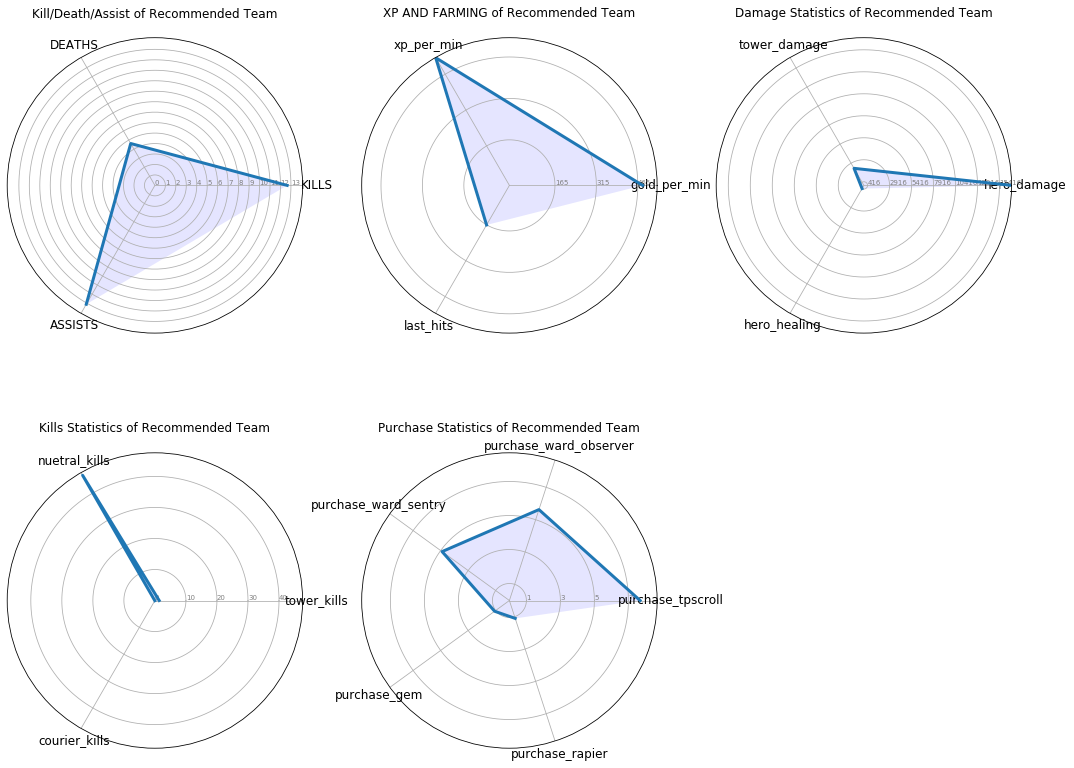

In [228]:
### BASIC KDA
categories = ['kills','deaths','assists']
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
#angles += angles[:1]
plt.figure(figsize=(18,14))
ax = plt.subplot(231, polar=True)
# Draw one axe per variable + add labels labels yet
plt.xticks(angles, ['KILLS','DEATHS','ASSISTS'], color='black', size=12)
plt.title("Kill/Death/Assist of Recommended Team")
yt = [ii for ii in range(int(max(groupedDataFrame[categories])) + 1)]
ax.set_rlabel_position(0)
plt.yticks(yt, yt, color="grey", size=7)
plt.ylim(0,max(groupedDataFrame[categories])+ 1)
ax.plot(angles, list(groupedDataFrame[categories]), linewidth=3, linestyle='solid')
ax.fill(angles, list(groupedDataFrame[categories]), 'b', alpha=0.1)

### XP AND FARMING
categories = ['gold_per_min','xp_per_min','last_hits']
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
#angles += angles[:1]
#plt.figure(figsize=(10,7))
ax = plt.subplot(232, polar=True)
# Draw one axe per variable + add labels labels yet
plt.xticks(angles, ['gold_per_min','xp_per_min','last_hits'], color='black', size=12)
plt.title("XP AND FARMING of Recommended Team")
yt = [ii for ii in range(int(min(groupedDataFrame[categories])),int(max(groupedDataFrame[categories])) + 1,150)]
ax.set_rlabel_position(0)
plt.yticks(yt, yt, color="grey", size=7)
plt.ylim(0,max(groupedDataFrame[categories])+ 1)
ax.plot(angles, list(groupedDataFrame[categories]), linewidth=3, linestyle='solid')
ax.fill(angles, list(groupedDataFrame[categories]), 'b', alpha=0.1)

### Damage Statistics
categories = ['hero_damage','tower_damage','hero_healing']
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
#angles += angles[:1]
#plt.figure(figsize=(10,7))
ax = plt.subplot(233, polar=True)
# Draw one axe per variable + add labels labels yet
plt.xticks(angles, ['hero_damage','tower_damage','hero_healing'], color='black', size=12)
plt.title("Damage Statistics of Recommended Team")
yt = [ii for ii in range(int(min(groupedDataFrame[categories])),int(max(groupedDataFrame[categories])) + 1,2500)]
ax.set_rlabel_position(0)
plt.yticks(yt, yt, color="grey", size=7)
plt.ylim(0,max(groupedDataFrame[categories])+ 1)
ax.plot(angles, list(groupedDataFrame[categories]), linewidth=3, linestyle='solid')
ax.fill(angles, list(groupedDataFrame[categories]), 'b', alpha=0.1)

### Kills Statistics
categories = ['tower_kills','nuetral_kills','courier_kills']
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
#angles += angles[:1]
#plt.figure(figsize=(10,7))
ax = plt.subplot(234, polar=True)
# Draw one axe per variable + add labels labels yet
plt.xticks(angles, ['tower_kills','nuetral_kills','courier_kills'], color='black', size=12)
plt.title("Kills Statistics of Recommended Team")
yt = [ii for ii in range(int(min(groupedDataFrame[categories])),int(max(groupedDataFrame[categories])) + 1,10)]
ax.set_rlabel_position(0)
plt.yticks(yt, yt, color="grey", size=7)
plt.ylim(0,max(groupedDataFrame[categories])+ 1)
ax.plot(angles, list(groupedDataFrame[categories]), linewidth=3, linestyle='solid')
ax.fill(angles, list(groupedDataFrame[categories]), 'b', alpha=0.1)

### Purchase Statistics
categories = ['purchase_tpscroll','purchase_ward_observer','purchase_ward_sentry','purchase_gem','purchase_rapier']
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
#angles += angles[:1]
#plt.figure(figsize=(10,7))
ax = plt.subplot(235, polar=True)
# Draw one axe per variable + add labels labels yet
plt.xticks(angles, ['purchase_tpscroll','purchase_ward_observer','purchase_ward_sentry','purchase_gem','purchase_rapier'], color='black', size=12)
plt.title("Purchase Statistics of Recommended Team")
yt = [ii for ii in range(int(min(groupedDataFrame[categories])),int(max(groupedDataFrame[categories])) + 1,2)]
ax.set_rlabel_position(0)
plt.yticks(yt, yt, color="grey", size=7)
plt.ylim(0,max(groupedDataFrame[categories])+ 1)
ax.plot(angles, list(groupedDataFrame[categories]), linewidth=3, linestyle='solid')
ax.fill(angles, list(groupedDataFrame[categories]), 'b', alpha=0.1)
